In [2]:
import Pkg; 
Pkg.activate(".."); Pkg.instantiate();
using RxInfer, Plots, Random, LinearAlgebra, StableRNGs, LaTeXStrings

  Activating project at `/ws/notebooks`


#### The Goal
The goal is to infer information about 2 objects. The idea is that the model processes ONE observation at a time, wich is related to the objects by a mixture. Lets start with the, hopefully simple, case where the switch for the mixture is known. 
#### Data Generation

In [3]:
rng = StableRNG(1234)

x1 = 1
x2 = 2
theta  = 0.6

function generate_data(rng, x1, x2, theta)
  s = rand(rng, Bernoulli(theta))
  if s
    y = x1 + rand(rng, Normal(0, 0.1))
    o = [1, 0]
  else
    y = x2 + rand(rng, Normal(0, 0.1))
    o = [0, 1]
  end
  return y, o
end

n = 1000
y_data = []
o_data = []
for i in 1:n
    yi, oi = generate_data(rng, x1, x2, theta)
    push!(y_data, yi)
    push!(o_data, oi)
end
println(y_data)
println(o_data)

Any[2.0905139726861126, 1.8705266555587259, 0.9313849445201189, 0.9910362943862812, 1.8092393385602814, 2.1671895725214427, 0.959236388923746, 0.919323529161528, 1.0673601904658014, 1.0052842330209832, 0.991956422389649, 1.988975653350349, 1.0372383618456726, 0.8753363901793302, 0.9971247942187655, 0.891649656517975, 1.1062016633872318, 1.0587471067604328, 0.9970740527636601, 0.9230432988568733, 0.9450625134495529, 1.942034580472478, 0.9046670261878739, 1.0476903629039218, 1.9030750807290613, 1.0437507297202433, 0.8515792134662773, 2.0883407654483648, 0.8928054148097796, 1.04768970504632, 1.1001990867593163, 2.0096116046622745, 2.004134093824233, 2.2116852658481383, 1.0345073015640902, 1.0776379058574006, 1.9638556154323483, 2.07683912805012, 1.0280373012572792, 1.9764181068108702, 1.00468441307305, 0.7912292190488202, 2.0469678309360493, 2.084061657846693, 0.9086998472526089, 1.9905250919646684, 2.120410975178924, 0.8957925460906841, 2.007266911460447, 1.2332672450985471, 2.1215457128

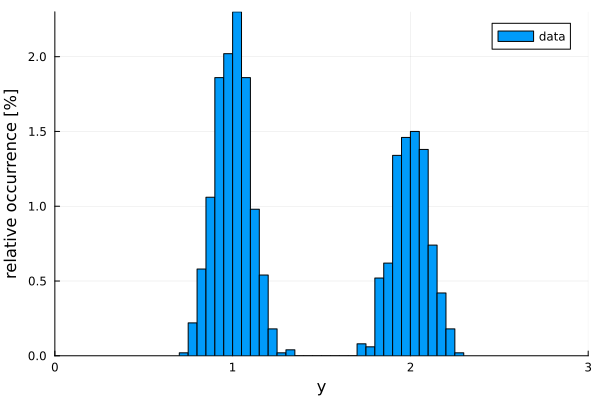

In [4]:
# Visualizing data
histogram(y_data, bins=50, label="data", normed=true)
xlims!(0, 3)
ylims!(0, Inf)
ylabel!("relative occurrence [%]")
xlabel!("y")    
    

In [5]:
# Defining the model
@model function model(y, o)

  m[1] ~ Normal(mean = 0, variance = 0.5)
  v[1] ~ Gamma(shape = 0.01, rate = 0.01)

  m[2] ~ Normal(mean = 2, variance = 0.5)
  v[2] ~ Gamma(shape = 0.01, rate = 0.01)
  
  for i in eachindex(y)
    s ~ Categorical(o[i])
    y[i] ~ NormalMixture(switch = s, m = m, p = v)
  end
end

#autoupdates = @autoupdates begin
  #M[1] = mean(q(m[1]))
  #M[2] = mean(q(m[2]))

  #V[1, 1], V[1, 2] = params(q(v[1]))
  #V[2, 1], V[2, 2] = params(q(v[2]))
#end

In [6]:
n_iterations = 10

init = @initialization begin
  q(s) = Categorical([0.5, 0.5])
  #q(m) = [Normal(1, 0.5), Normal(2, 0.5)]
  q(m) = [NormalMeanVariance(-2.0, 1e3), NormalMeanVariance(2.0, 1e3)]
  q(v) = [Gamma(1, 1), Gamma(1, 1)]
end

results = infer(
  model           = model(),
  constraints     = MeanField(),
  #autoupdates     = autoupdates,
  iterations      = n_iterations,
  initialization  = init,
  data            = (y = y_data, o = o_data),  
  #addons          = AddonLogScale(),
  #postprocess     = UnpackMarginalPostprocess(),
  free_energy     = true,
)

Inference results:
  Posteriors       | available for (m, s, v)
  Free Energy:     | Real[15891.1, 12712.2, 12240.2, 12240.2, 12240.2, 12240.2, 12240.2, 12240.2, 12240.2, 12240.2]


In [7]:
m1 = [results.posteriors[:m][i][1] for i in 1:n_iterations]
m2 = [results.posteriors[:m][i][2] for i in 1:n_iterations]
w1 = [results.posteriors[:v][i][1] for i in 1:n_iterations]
w2 = [results.posteriors[:v][i][2] for i in 1:n_iterations];


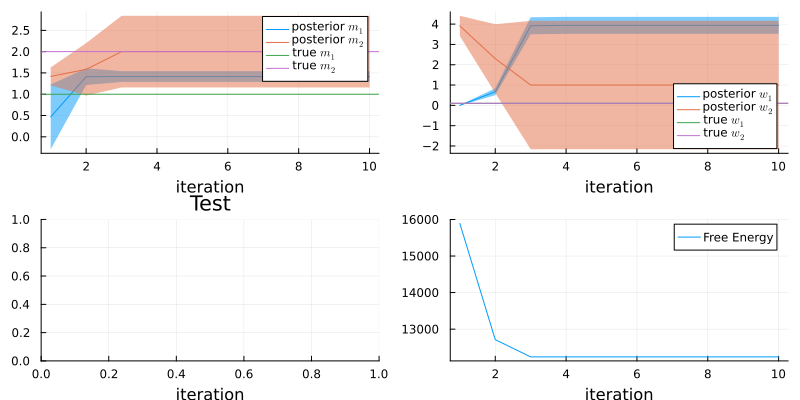

In [8]:
mp = plot(mean.(m1), ribbon = std.(m1) .|> sqrt, label = L"posterior $m_1$")
mp = plot!(mean.(m2), ribbon = std.(m2) .|> sqrt, label = L"posterior $m_2$")
mp = plot!(mp, [ x1 ], seriestype = :hline, label = L"true $m_1$")
mp = plot!(mp, [ x2 ], seriestype = :hline, label = L"true $m_2$")

wp = plot(mean.(w1), ribbon = std.(w1) .|> sqrt, label = L"posterior $w_1$", legend = :bottomright)
wp = plot!(wp, mean.(w2), ribbon = std.(w2) .|> sqrt, label = L"posterior $w_2$")
wp = plot!(wp, [ 0.1 ], seriestype = :hline, label = L"true $w_1$")
wp = plot!(wp, [ 0.1 ], seriestype = :hline, label = L"true $w_2$")

swp = plot(title = "Test")

fep = plot(results.free_energy, label = "Free Energy", legend = :topright)

plot(mp, wp, swp, fep, layout = @layout([ a b; c d ]), size = (800, 400))
xlabel!("iteration")


#### Not Quite
The model used here is not quite the model I envisioned. This way of formulating the mixture feels a bit odd. Lets see if I can alter the model

In [30]:
#Model
@model function obj_mix_model(y, o)
  x1 ~ Normal(mean=0, variance=1)
  x2 ~ Normal(mean=0, variance=1)

  for i in eachindex(y)
    s[i] ~ Categorical(o[i])
    O[i] ~ Mixture(switch=s[i], inputs=[x1, x2])
    y[i] ~ Normal(mean=O[i], variance=0.1)
  end
end

In [33]:
results = infer(
  model           = obj_mix_model(),
  #constraints     = MeanField(),
  #iterations      = 100,
  #initialization  = init,
  data            = (y = y_data, o = o_data),  
  addons          = AddonLogScale(),
  postprocess     = UnpackMarginalPostprocess(),
  returnvars      = (x1 = KeepLast(), x2 = KeepLast()),
  free_energy     = true,
)

MethodError: MethodError: no method matching getlocalclusters(::MixtureNode{2})
The function `getlocalclusters` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  getlocalclusters(!Matched::ReactiveMP.StandaloneDistributionNode)
   @ ReactiveMP ~/.julia/packages/ReactiveMP/cZQEH/src/nodes/predefined/distribution/distribution.jl:14
  getlocalclusters(!Matched::FactorNode)
   @ ReactiveMP ~/.julia/packages/ReactiveMP/cZQEH/src/nodes/nodes.jl:201
